In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import nengo
from nengo.neurons import FourierSinusoid
from nengo.processes import Piecewise
import math as m
import itertools
plt.rcParams['figure.figsize'] = [12, 6]

This notebook was used to test different encoding strategies and the hidden layer weight CTRNN dynamics.

In [2]:
# Encoding strategy

s_pi = 0.1 # Half of the hidden neuron response's wavelength
max_transmission = 1 # Max output of a hidden neuron

intercept_vals = [0,1/8,1/4,3/8] # Intercept values that correlate with hidden neuron bias terms
rate_vals = s_pi*np.array([1/2,1,3/2]) # Gain coefficients that scale encoded inputs to the hidden neurons

# Selected encoding vectors for the 4 values (w,x,a,e) that are encoded into the neural population
encoder_vals = [[1,1,1,1],[1,1,1,-1],[1,1,-1,1],[1,-1,1,1],[1,1,-1,-1],[1,-1,1,-1],[1,-1,-1,1],[1,-1,-1,-1]]

num_intercepts = len(intercept_vals)
num_rates = len(rate_vals)
num_encoders = len(encoder_vals)
num_neurons = np.int_(num_rates*num_intercepts*num_encoders)

intercepts = np.zeros(num_neurons)
rates = np.zeros(num_neurons)
encoders = np.zeros(shape=(num_neurons, 4))

j = 0
for ir in range(num_rates):
    for ii in range(num_intercepts):
        for ie in range(num_encoders):
            encoders[j,:] = encoder_vals[ie]
            intercepts[j] = intercept_vals[ii]
            rates[j] = rate_vals[ir]
            j += 1
            
print(num_neurons)

96


In [4]:
# All times in seconds
tau = 100
mu = 50
dt = 0.001 # CTRNN simulation timestep

# Initialize these variables for later use
x_val = 0.0
a_val = 0.0
e_val = 0.0

B = 0.56 # DFA constant feedback matrix term (in this case just a single value)

# The feedback connections
def feedback(vec):
    w, x, a, e = vec
    dw = -B*e*x*a*(1-a)*mu
    return [w + dw*tau]

In [5]:
seed=np.random.randint(1, 10000000)
model = nengo.Network()
with model:
    # The ensembles and recurrent connections for the CTRNNs
    CTRNN = nengo.Ensemble(num_neurons, dimensions=4, radius=2., n_eval_points=100000,
                           encoders=encoders, intercepts=intercepts, max_rates=rates, 
                           neuron_type=nengo.neurons.FourierSinusoid(max_overall_rate=max_transmission, s_pi=s_pi))
    
    # Recurrent connection
    nengo.Connection(CTRNN, CTRNN[0], function=feedback, synapse=tau)
    
    # External inputs
    input_x = nengo.Node(lambda t: x_val)
    input_a = nengo.Node(lambda t: a_val)
    input_e = nengo.Node(lambda t: e_val)
    
    # External connections
    nengo.Connection(input_x, CTRNN[1])
    nengo.Connection(input_a, CTRNN[2])
    nengo.Connection(input_e, CTRNN[3])
        
    # Record values
    CTRNN_probe = nengo.Probe(CTRNN, synapse=0, sample_every=0.01)

In [7]:
# Run simulation
with nengo.Simulator(model, dt=dt, seed=seed) as sim:
    x_val = 0.25
    a_val = 0.5
    e_val = -0.1
    sim.run(0.5)
    
    e_val = 0.1
    sim.run(0.5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

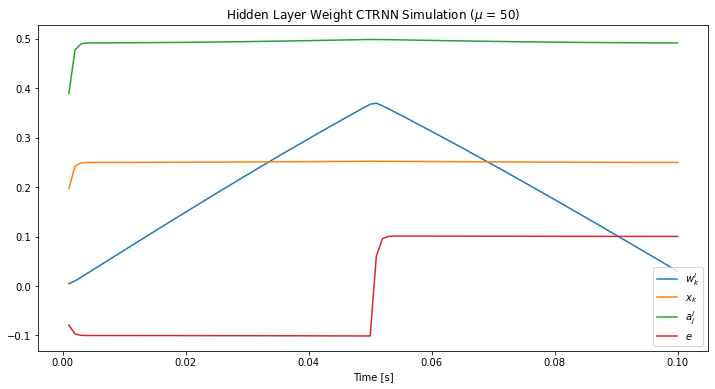

In [11]:
plt.figure()
plt.plot(sim.trange()[0:100:1], sim.data[CTRNN_probe])
plt.xlabel("Time [s]")
plt.title("Hidden Layer Weight CTRNN Simulation ($\mu$ = 50)")
plt.legend(["$w^l_k$", "$x_k$", "$a^l_j$", "$e$"])

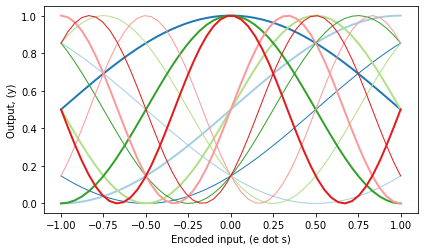

In [13]:
# Generate neuron response curves where each neuron is visibly unique

from nengo.utils.ensemble import tuning_curves
from nengo.utils.ensemble import response_curves

eval_points, responses = response_curves(CTRNN, sim)

fig = plt.figure(1, figsize=(6,3.6), dpi=72)
cm = plt.get_cmap('Paired') 
cNorm  = colors.Normalize(vmin=0, vmax=num_neurons//num_encoders*2)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

for i in range(0, int(num_neurons//num_encoders)):
    lw = 2-(i % 2)
    colorVal = scalarMap.to_rgba(2*(i//2)+1)
    plt.plot(eval_points, responses[:,i*(num_encoders)]/max_transmission, lw=lw, color=colorVal)

plt.xlabel("Encoded input, (e dot s)")
plt.ylabel("Output, (y)")
fig.tight_layout()

# The neural population should provide a fourier basis for representing encoded values